<a href="https://colab.research.google.com/github/zenikigai/Pengembangan_Machine_Learning_IDcamp2023/blob/main/Model_Machine_Learning_dengan_Data_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML Model with Time Series Dataset

4 stars rating.

In [72]:
!gdown 1ryiwEOzFDAgdFtk3gpq3ypSJ5m_cW1HE

Downloading...
From: https://drive.google.com/uc?id=1ryiwEOzFDAgdFtk3gpq3ypSJ5m_cW1HE
To: /content/3k_dataset.csv
100% 140k/140k [00:00<00:00, 3.35MB/s]


In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

In [76]:
def load_data(file_path):
    return pd.read_csv(file_path)

In [77]:
def preprocess_data(data, target_column):
  missing_values = data.isnull().sum()
  print("Columns with missing values:")
  print(missing_values[missing_values > 0])

  scaler = MinMaxScaler(feature_range=(0, 1))
  data[target_column] = scaler.fit_transform(data[[target_column]])

  return data, scaler

In [78]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        sequences.append(seq)
    return np.array(sequences)

In [93]:
def build_model_mae(input_shape, learning_rate):
    model = Sequential()
    model.add(Bidirectional(LSTM(32, activation='relu', input_shape=input_shape)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="relu"))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='mae', optimizer=optimizer, metrics=["mae"])
    return model

In [94]:
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0 and epoch > 0:
        lr = lr * 0.9
    return lr

In [95]:
def plot_results(history, y_val, y_pred):
    plt.style.use('seaborn-darkgrid')

    plt.figure(figsize=(20, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', color='tab:blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', color='tab:orange')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(y_val, label='Actual', color='tab:blue')
    plt.plot(y_pred, label='Predicted', color='tab:orange')
    plt.title('Actual vs Predicted Values')
    plt.xlabel('Samples')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()

    plt.savefig('training_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

In [96]:
def evaluate_model_mae(model, X_val, y_val, threshold_mae, scaler, history):
    y_pred = model.predict(X_val)

    plot_results(history, y_val, y_pred)

    mae = np.mean(np.abs(y_val - y_pred))
    scaled_mae = mae * (scaler.data_max_ - scaler.data_min_)
    print(f'MAE: {mae}, Scaled MAE: {scaled_mae}')

    if mae < threshold_mae:
        print("Model memenuhi kriteria MAE < 10% skala data.")
    else:
        print("Model tidak memenuhi kriteria MAE < 10% skala data.")

In [97]:
seq_length = 50
learning_rate = 0.001
batch_size = 128
epochs = 100
random_state = 42

In [98]:
file_path = "3k_dataset.csv"  # Change this to your dataset
df = load_data(file_path)
print("Jumlah sampel pada dataset: ",df.shape[0])

if df.shape[0] < 1000:
    raise ValueError("Dataset must have at least 1000 samples.")

Jumlah sampel pada dataset:  3000


In [99]:
target_column = 'Average'
df, scaler = preprocess_data(df, target_column)

Columns with missing values:
Series([], dtype: int64)


In [86]:
sequences = create_sequences(df[target_column].values.reshape(-1, 1), seq_length)

In [100]:
X = sequences[:, :-1]
y = sequences[:, -1]

In [101]:
threshold_mae = (df[target_column].max() - df[target_column].min()) * 10/100

In [102]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=random_state, shuffle=False)

In [103]:
model_mae = build_model_mae(input_shape=(X_train.shape[1], X_train.shape[2]), learning_rate=learning_rate)
lr_schedule = LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

In [104]:
print("Jumlah sampel pada dataset: ",df.shape[0])
history_mae = model_mae.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_schedule]
)

Jumlah sampel pada dataset:  3000
Epoch 1/100
19/19 [==============================] - 4s 63ms/step - loss: 0.1041 - mae: 0.1041 - val_loss: 0.0813 - val_mae: 0.0813 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 1s 41ms/step - loss: 0.0882 - mae: 0.0882 - val_loss: 0.0794 - val_mae: 0.0794 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 1s 46ms/step - loss: 0.0856 - mae: 0.0856 - val_loss: 0.0766 - val_mae: 0.0766 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 1s 46ms/step - loss: 0.0831 - mae: 0.0831 - val_loss: 0.0758 - val_mae: 0.0758 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 1s 42ms/step - loss: 0.0823 - mae: 0.0823 - val_loss: 0.0748 - val_mae: 0.0748 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - 1s 43ms/step - loss: 0.0810 - mae: 0.0810 - val_loss: 0.0741 - val_mae: 0.0741 - lr: 0.0010
Epoch 7/100
19/19 [==============================] - 1s 46ms/step - loss: 0.0800 - mae: 0.0800 -

19/19 [==============================] - 0s 8ms/step


<ipython-input-95-0f24cef4466b>:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


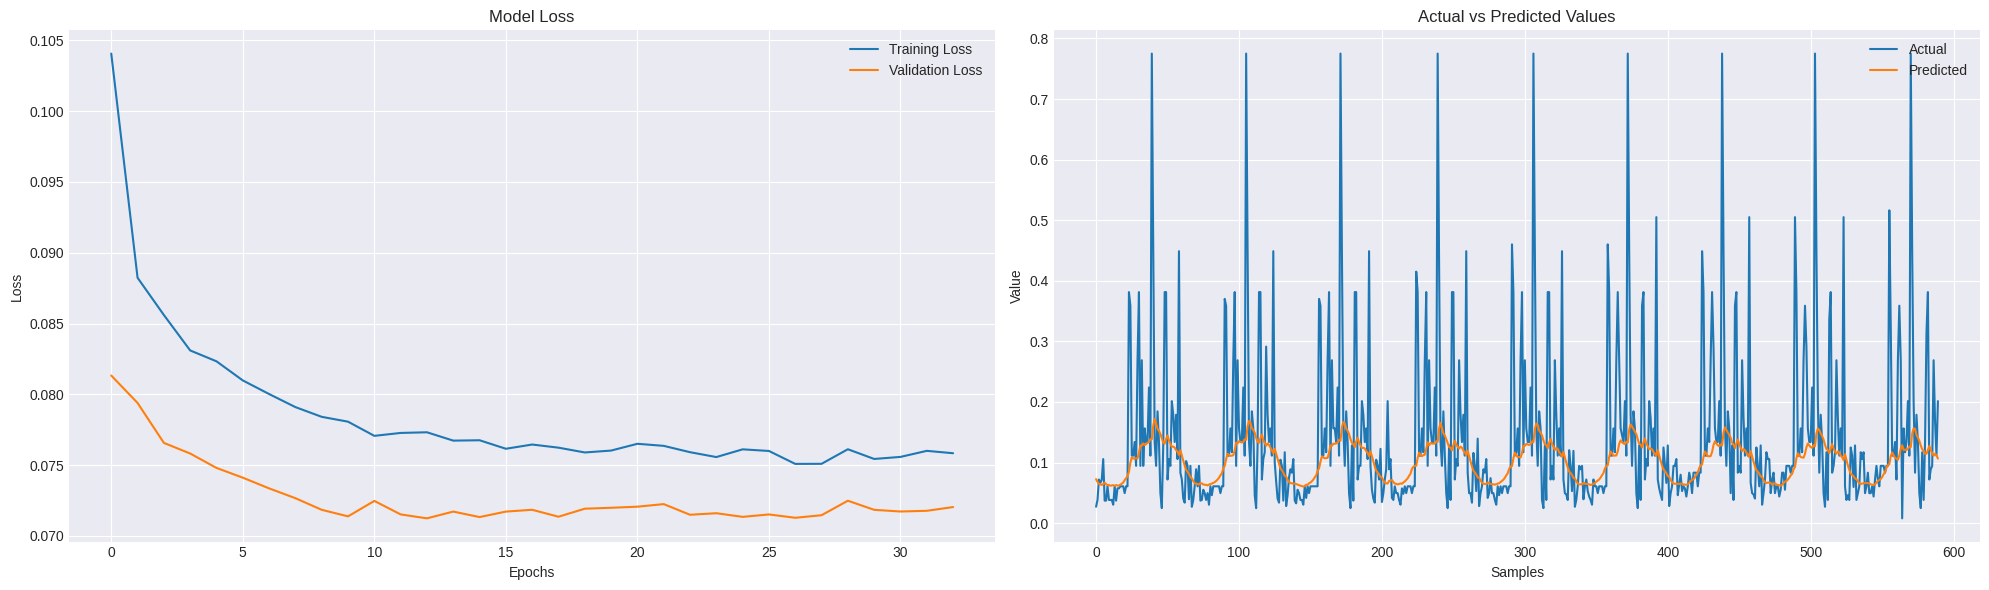

MAE: 0.0712443958257469, Scaled MAE: [31.66813394]
Model memenuhi kriteria MAE < 10% skala data.


In [105]:
evaluate_model_mae(model_mae, X_val, y_val, threshold_mae, scaler, history_mae)